# Classify based on functional types

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [7]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)
rscl_df = pd.DataFrame(rscl_data, columns=[f"Feat_{i}" for i in range(300)])

(10500, 943)
The Echo pulse occurs at timestep: 628


## Classification based on timeseries

In [57]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [62]:
def print_score(m, X_train, X_test, y_train, y_test):
    res = [f1_score(m.predict(X_train), y_train, average='weighted'), f1_score(m.predict(X_test), y_test, average='weighted'),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)


In [63]:
model = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features="sqrt",
                          n_jobs=-1, oob_score=True)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(rscl_df, params['stencil_type'],
                                                    test_size=0.2, random_state=1,
                                                    stratify=params['stencil_type'])

In [65]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [66]:
print_score(model,X_train, X_test, y_train, y_test )

[0.9986901814697138, 0.9737611964823905, 0.9986904761904762, 0.9738095238095238, 0.9686904761904762]


In [67]:
fi = pd.DataFrame(np.array([rscl_df.columns.tolist(),model.feature_importances_]).T,
                  columns=['feat','fi'])
fi["fi"] = pd.to_numeric(fi["fi"], downcast="float")
fi.head()

,feat,fi
0,Feat_0,0.002584
1,Feat_1,0.001395
2,Feat_2,0.002815
3,Feat_3,0.001171
4,Feat_4,0.001311


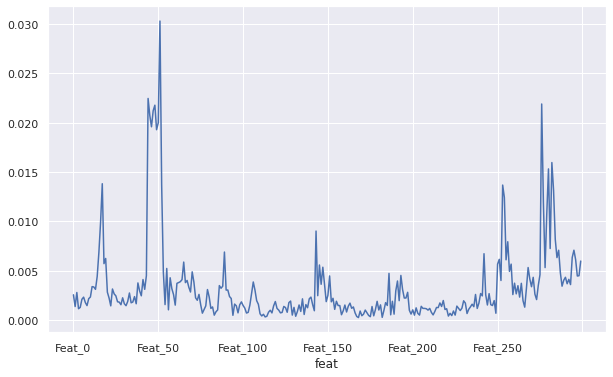

In [68]:
fi.plot('feat', 'fi', figsize=(10,6), legend=False);

In [69]:
def plot_fi(fi): return fi.plot('feat', 'fi', 'barh', figsize=(12,7), legend=False)

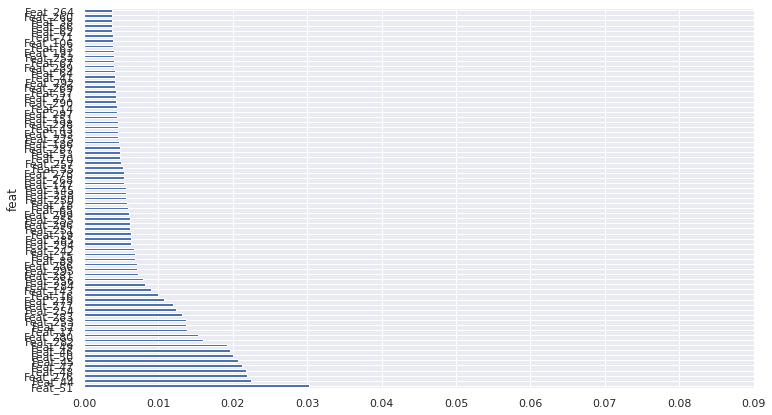

In [70]:
fi.sort_values('fi', ascending=False, inplace=True)
plot_fi(fi[:75])
plt.xticks(np.arange(0,0.10, 0.01))
plt.show()

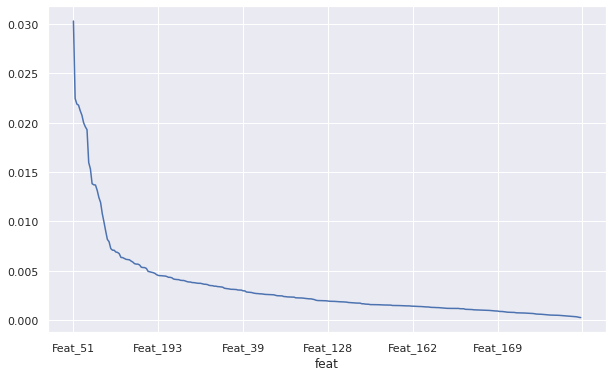

In [71]:
fi.plot('feat', 'fi', figsize=(10,6), legend=False);

In [72]:
# choose cutoff at 0.005

to_keep_cols = fi[fi.fi >= 0.005 ].feat
df_keep = rscl_df[to_keep_cols]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, params['stencil_type'],
                                                    test_size=0.2, random_state=1,
                                                    stratify=params['stencil_type'])

In [74]:
model2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)


In [75]:
model2.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [81]:
y_test

112      0.0
2178     0.0
2327     0.0
8599     2.0
6472     1.0
        ... 
252      0.0
6363     1.0
7718     2.0
6576     1.0
10204    2.0
Name: stencil_type, Length: 2100, dtype: float32

In [80]:
f1_score(X_test, y_test)

ValueError: ignored

In [76]:
print_score(model2, X_train, X_test, y_train, y_test)

ValueError: ignored